# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
#!pip install datasets

Импорт необходимых библиотек

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [22]:
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [23]:
sentences = []
for sentence in tqdm(dataset['train']['text']):
    sentences.extend([x.lower() for x in sent_tokenize(sentence, language='english') if len(x)< 128])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [24]:
len(sentences)

177208

Посчитаем для каждого слова его встречаемость.

In [25]:
words = Counter()
for text in tqdm(sentences):
    for word in word_tokenize(text):
        words[word] += 1

  0%|          | 0/177208 [00:00<?, ?it/s]

In [26]:
len(words)

59186

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [27]:
vocab_size = 4000
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
for key, value in sorted(words.items(), key=lambda x: x[1], reverse=True)[:4000]:
    vocab.add(key)

In [28]:
len(vocab)

4004

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [29]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [30]:
class WordDataset:
    def __init__(self, sentences):

        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence
    
    def __len__(self) -> int:
        return len(self.data)

In [31]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [32]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 512

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

In [33]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, n_layers:int = 1, rnn_type: str = 'RNN'):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers = n_layers, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers = n_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers = n_layers, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        out = self.linear(self.non_lin(output))
        projection = self.projection(self.non_lin(out))

        return projection

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [34]:
def evaluate(model, criterion, dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [35]:
def train_loop(model, train_loader, eval_dataloader, optimizer, criterion, epochs):
    perplexity = []
    losses = []
    for epoch in range(epochs):
        model.train()
        loss_ep = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            loss_ep.append(loss.item())
        perplexity.append(evaluate(model, criterion, eval_dataloader))
        losses.append(sum(loss_ep) / len(loss_ep))
    return perplexity, losses

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
hidden_dim = 256
num_epoch = 10
n_layers = 1
loss_v = {}
perp_v = {}

for rrn_type in ['RNN', 'GRU', 'LSTM']:

    model = LanguageModel(hidden_dim=hidden_dim, vocab_size=len(vocab), n_layers = n_layers, rnn_type = rrn_type).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    losses, perplexities = train_loop(model, train_dataloader, eval_dataloader, optimizer, criterion, num_epoch)
    loss_v[rrn_type] = losses
    perp_v[rrn_type] = perplexities
    del model
    torch.cuda.empty_cache()
    print('----------')

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

----------


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

----------


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

----------


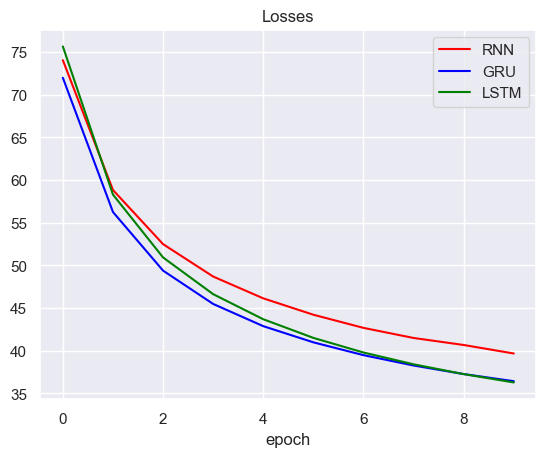

Минимальная perplexities для подхода RNN: 3.69
Минимальная perplexities для подхода GRU: 3.6
Минимальная perplexities для подхода LSTM: 3.6


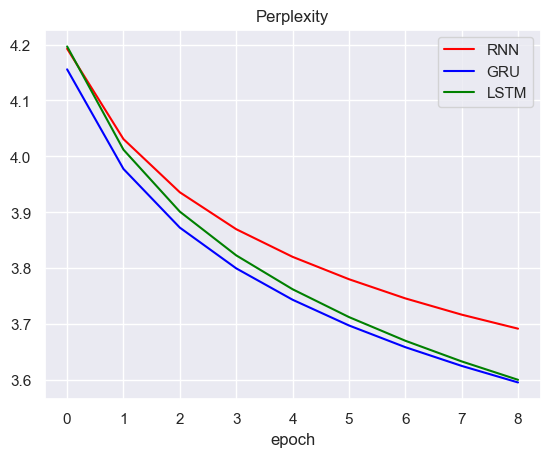

In [32]:
for (name, values), color in zip(loss_v.items(), ['red', 'blue', 'green']):
    plt.plot(np.arange(len(loss_v[name])), loss_v[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for (name, values), color in zip(perp_v.items(), ['red', 'blue', 'green']):
    plt.plot(np.arange(len(perp_v[name][1:])), perp_v[name][1:], color=color, label=name)
    print(f"Минимальная perplexities для подхода {name}: {round(min(perp_v[name]), 2)}")

plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучше всего с генерацией справляется модель LSTM. Также видим, что кол-во эпох недостаточно для качественного обучения. В дальнейших экспериментах буду использовать LSTM

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [15]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, n_layers:int = 1, dropout_rate = 0.1, use_normalization: bool = False):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_dim) if use_normalization else None
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p = dropout_rate)
        self.use_normalization = use_normalization

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        if self.use_normalization:
            output = output.permute(0, 2, 1)  # [batch_size, hidden_dim, seq_len]
            output = self.norm(output)
            output = output.permute(0, 2, 1)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.linear(self.non_lin(output)))

        return projection

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
hidden_dim = 256
num_epoch = 15
dropout_rate =  0.1
num_layers = 1
loss_v = {}
perp_v = {}

df = pd.DataFrame(columns=['use_normalization', 'dropout_rate', 'losses', 'perplexities'])

for use_it in [False, True]:
    for dropout_rate in [0.1, 0.2, 0.3]:
        model = LanguageModel(hidden_dim=hidden_dim, vocab_size=len(vocab), n_layers = num_layers, 
                       dropout_rate = dropout_rate, use_normalization = use_it).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        losses, perplexities = train_loop(model, train_dataloader, eval_dataloader, 
                                          optimizer, criterion, num_epoch)
        train_name = 'use_normalization:{}, dropout_rate:{}'.format(use_it, dropout_rate)
        loss_v[train_name] = losses
        perp_v[train_name] = perplexities
        del model
        torch.cuda.empty_cache()

        results = {
        'use_normalization': use_it,
        'dropout_rate': dropout_rate,
        'losses': losses,
        'perplexities': perplexities
        }
        new_df = pd.DataFrame([results])
        # Добавляем новую строку в DataFrame
        df = pd.concat([df, new_df], ignore_index=True)

        # Сохраняем DataFrame в CSV-файл
        df.to_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\use_normalization_dropout_rate.csv', index=False, columns=['use_normalization', 'dropout_rate', 'losses', 'perplexities'])
        


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

C:\Users\Anna\AppData\Local\Temp\ipykernel_18008\3292218115.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

In [22]:
def string_to_list(string):
    # Удалите скобки и пробелы
    string = string.strip('[]').replace(' ', '')
    # Разделите строку по запятой
    return [float(x) for x in string.split(',')]

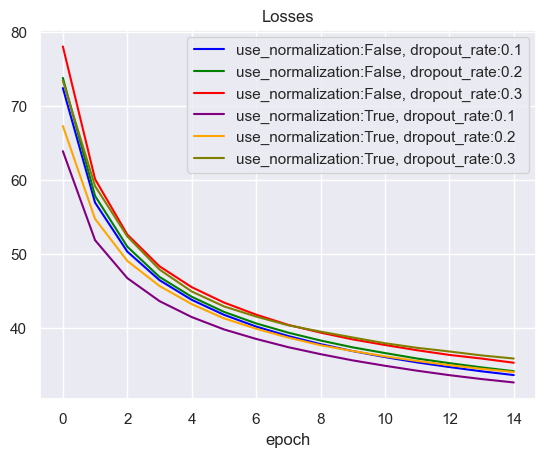

Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.1: 3.53
Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.2: 3.57
Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.3: 3.62
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.1: 3.49
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.2: 3.54
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.3: 3.59


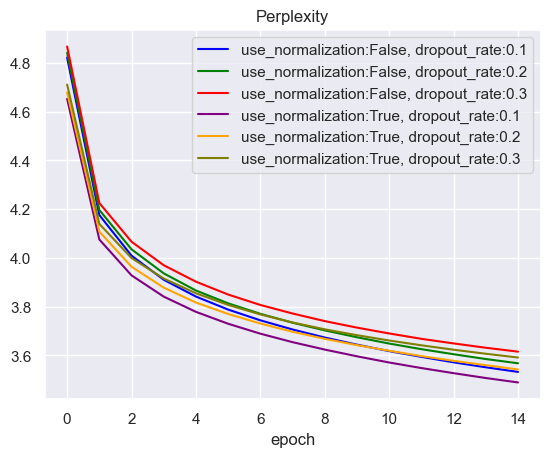

In [31]:
df = pd.read_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\use_normalization_dropout_rate.csv') 

colors = ['blue', 'green', 'red', 'purple', 'orange', 'olive']

for index, row in df.iterrows():
    use_normalization = row['use_normalization']
    dropout_rate = row['dropout_rate']
    data_loss_v = string_to_list(row['losses'])
    plt.plot(data_loss_v, label='use_normalization:{}, dropout_rate:{}'.format(use_normalization, dropout_rate), color=colors[index % len(colors)])

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for index, row in df.iterrows():
    use_normalization = row['use_normalization']
    dropout_rate = row['dropout_rate']
    data_perplexities = string_to_list(row['perplexities'])
    plt.plot(data_perplexities, label='use_normalization:{}, dropout_rate:{}'.format(use_normalization, dropout_rate), color=colors[index % len(colors)])
    print('Минимальная perplexities для подхода use_normalization:{}, dropout_rate:{}: {}'.format(use_normalization, dropout_rate, round(min(data_perplexities), 2)))

plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

* По результат видно, что наличие нормализации стабильно улучшает результат, например:use_normalization:False, dropout_rate:0.1: 3.53 vs use_normalization:True, dropout_rate:0.1: 3.49
* Увеличение dropout_rate наоборот ухудшает результат и требуется отдельное сравнение модели с нормализацией, но без dropout_rate. Обучение также должно проходить 15 эпох

Для этого создаем навый класс модели

In [37]:
class LanguageModel_normalize(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, n_layers:int = 1, use_normalization: bool = False):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers = n_layers, batch_first=True)
        self.norm = nn.BatchNorm1d(hidden_dim) if use_normalization else None
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.use_normalization = use_normalization
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        if self.use_normalization:
            output = output.permute(0, 2, 1)  # [batch_size, hidden_dim, seq_len]
            output = self.norm(output)
            output = output.permute(0, 2, 1)  # [batch_size, seq_len, hidden_dim]
        out = self.linear(self.non_lin(output))
        projection = self.projection(self.non_lin(out))

        return projection

In [20]:
hidden_dim = 256
num_epoch = 15
num_layers = 1
df = pd.read_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\use_normalization_dropout_rate.csv') 
loss_v = {}
perp_v = {}
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

for use_it in [False, True]:
    model = LanguageModel_normalize(hidden_dim=hidden_dim, vocab_size=len(vocab), n_layers = num_layers, use_normalization = use_it).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    losses, perplexities = train_loop(model, train_dataloader, eval_dataloader, 
                                        optimizer, criterion, num_epoch)
    train_name = 'use_normalization:{}, dropout_rate:0'.format(use_it, 0)
    loss_v[train_name] = losses
    perp_v[train_name] = perplexities
    del model
    torch.cuda.empty_cache()

    results = {
    'use_normalization': use_it,
    'dropout_rate': 0,
    'losses': losses,
    'perplexities': perplexities
    }
    new_df = pd.DataFrame([results])
    # Добавляем новую строку в DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

    # Сохраняем DataFrame в CSV-файл
    df.to_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\use_normalization_dropout_rate.csv', index=False, columns=['use_normalization', 'dropout_rate', 'losses', 'perplexities'])


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

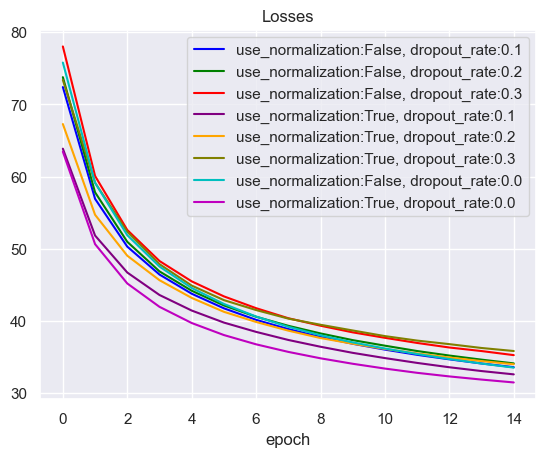

Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.1: 3.53
Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.2: 3.57
Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.3: 3.62
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.1: 3.49
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.2: 3.54
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.3: 3.59
Минимальная perplexities для подхода use_normalization:False, dropout_rate:0.0: 3.48
Минимальная perplexities для подхода use_normalization:True, dropout_rate:0.0: 3.38


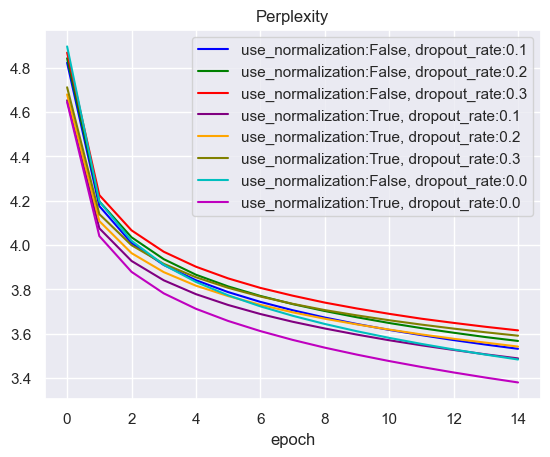

In [23]:
df = pd.read_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\use_normalization_dropout_rate.csv') 

colors = ['blue', 'green', 'red', 'purple', 'orange', 'olive', 'c', 'm']

for index, row in df.iterrows():
    use_normalization = row['use_normalization']
    dropout_rate = row['dropout_rate']
    data_loss_v = string_to_list(row['losses'])
    plt.plot(data_loss_v, label='use_normalization:{}, dropout_rate:{}'.format(use_normalization, dropout_rate), color=colors[index % len(colors)])

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for index, row in df.iterrows():
    use_normalization = row['use_normalization']
    dropout_rate = row['dropout_rate']
    data_perplexities = string_to_list(row['perplexities'])
    plt.plot(data_perplexities, label='use_normalization:{}, dropout_rate:{}'.format(use_normalization, dropout_rate), color=colors[index % len(colors)])
    print('Минимальная perplexities для подхода use_normalization:{}, dropout_rate:{}: {}'.format(use_normalization, dropout_rate, round(min(data_perplexities), 2)))

plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

Как мы видим, использование нормализации без dropout улучшает perplexity с 3.48 до 3.38, что является наилучшим показателем

## Третий эксперимент

В этом эксперименте я решила изменить greed search generation на beam search. Для начала обучим модель с наилучшими параметрами. Из предыдущих графиков видно, что 15 эпох недостаточно для качественного обучения, поэтому num_epoch = 25

In [36]:
def train_loop_with_save(model, train_loader, eval_dataloader, optimizer, criterion, epochs, path_to_save):
    best_perp = 1000
    perplexity = []
    losses = []
    for epoch in range(epochs):
        model.train()
        loss_ep = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            loss_ep.append(loss.item())
        cur_perp = evaluate(model, criterion, eval_dataloader)
        if cur_perp < best_perp:
            best_perp = cur_perp
            torch.save(model.state_dict(), path_to_save)
        perplexity.append(cur_perp)
        losses.append(sum(loss_ep) / len(loss_ep))
    return perplexity, losses, model

In [39]:
del model
torch.cuda.empty_cache()

In [40]:

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
path_to_save = r'E:\Iliushina_files\DLS\2_part\3. language models\best_lang_modeling_model_256.pth'
model = LanguageModel_normalize(hidden_dim=516, vocab_size=len(vocab), n_layers = 1, use_normalization = True).to(device)
optimizer = torch.optim.Adam(model.parameters())
losses, perplexities, model = train_loop_with_save(model, train_dataloader, eval_dataloader, 
                                    optimizer, criterion, 25, path_to_save)

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

C:\Users\Anna\AppData\Local\Temp\ipykernel_5216\2166646452.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


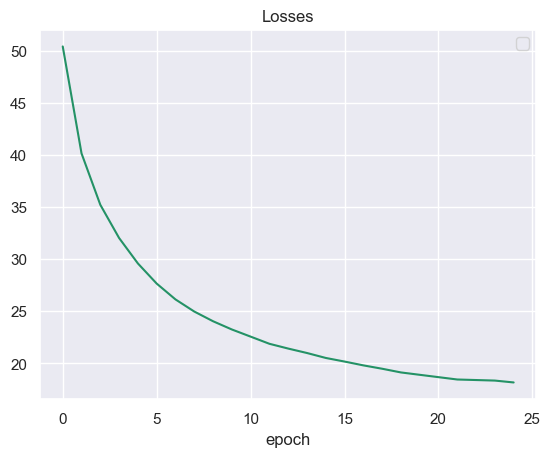

In [35]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [32]:
print('Минимальная perplexities: {} и loss: {}'.format(round(min(losses), 2), round(min(perplexities), 2)))

Минимальная perplexities: 18.17 и loss: 2.15


In [48]:
model = LanguageModel_normalize(hidden_dim=512, vocab_size=len(vocab), n_layers = 2, use_normalization = True).to(device)
model.load_state_dict(torch.load(r'E:\Iliushina_files\DLS\2_part\3. language models\best_lang_modeling_model.pth', weights_only=True))
model.to(device)

CharLM_normalize(
  (embedding): Embedding(4004, 512)
  (rnn): LSTM(512, 512, num_layers=2, batch_first=True)
  (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (projection): Linear(in_features=512, out_features=4004, bias=True)
  (non_lin): Tanh()
)

In [43]:
def generate_sequence_greedy(model, starting_seq: str, max_seq_len: int = 128) -> str:
    model = model.to(device)
    initial_len = len(word_tokenize(starting_seq))
    input_ids = [word2ind['<bos>']] + [word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len - initial_len):
            next_char_distribution = model(input_ids)[:, -1, :]  # Берем последний символ в последовательности
            next_char = next_char_distribution.argmax(dim=-1)
            next_char = next_char.unsqueeze(1)
            input_ids = torch.cat([input_ids, next_char], dim=1)

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids[0]])

    return words

Для beam_search

In [44]:
import heapq
from torch.nn.functional import log_softmax
class Beam(object):
    def __init__(self, beam_width):
        self.heap = list()
        self.beam_width = beam_width

    def add(self, prob, complete, prefix):
        heapq.heappush(self.heap, (prob, complete, prefix))
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)

    def __iter__(self):
        return iter(self.heap)

def probabilities_function(model, prefix, word2ind, device):
    input_ids = torch.LongTensor([word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(prefix)]).to(device)
    model.eval()
    with torch.no_grad():
        next_char_distribution = model(input_ids.unsqueeze(0))[:, -1, :]  # Берем последний символ в последовательности
        log_probs = log_softmax(next_char_distribution, dim=-1)
        probs = torch.exp(log_probs)
        topk_probs, topk_indices = probs.topk(len(word2ind), dim=-1)
        return [(prob.item(), ind2word[idx.item()]) for prob, idx in zip(topk_probs[0], topk_indices[0])]

def beamsearch(model, starting_seq, word2ind, ind2word, beam_width=10, clip_len=-1, device='cpu'):
    starting_seq_words = starting_seq.split()
    starting_seq_words = [word if word in word2ind else '<unk>' for word in starting_seq_words]
    starting_seq = ' '.join(starting_seq_words)

    prev_beam = Beam(beam_width)
    prev_beam.add(1.0, False, '<bos> ' + starting_seq)
    while True:
        curr_beam = Beam(beam_width)

        for (prefix_prob, complete, prefix) in prev_beam:
            if complete == True:
                curr_beam.add(prefix_prob, True, prefix)
            else:
                for (next_prob, next_word) in probabilities_function(model, prefix, word2ind, device):
                    if next_word == '<eos>':
                        curr_beam.add(prefix_prob * next_prob, True, prefix + ' ' + next_word)
                    else:
                        curr_beam.add(prefix_prob * next_prob, False, prefix + ' ' + next_word)

        (best_prob, best_complete, best_prefix) = max(curr_beam)
        if best_complete == True or len(best_prefix.split()) - 1 == clip_len:
            return (best_prefix, best_prob)

        prev_beam = Beam(beam_width)
        for (prefix_prob, complete, prefix) in curr_beam:
            prev_beam.add(prefix_prob, complete, prefix)

In [63]:
starting_seq = 'a good game'
max_len = 8
generated_seq_greedy = generate_sequence_greedy(model, starting_seq =starting_seq, max_seq_len = max_len)
beam_w = 5
generated_seq, prob = beamsearch(model, starting_seq, word2ind, ind2word, beam_width=beam_w, clip_len=max_len, device=device)
print("Best sequence from greedy method:", generated_seq_greedy)
print("Best sequence from beam method:", generated_seq)

Best sequence from greedy method: <bos> a good game flying some incident stinks flying
Best sequence from beam method: <bos> a good game pat arnold pitch beach haunted


In [64]:
starting_seq = 'road'
max_len = 5
generated_seq_greedy = generate_sequence_greedy(model, starting_seq =starting_seq, max_seq_len = max_len)
beam_w = 3
generated_seq, prob = beamsearch(model, starting_seq, word2ind, ind2word, beam_width=beam_w, clip_len=max_len, device=device)
print("Best sequence from greedy method:", generated_seq_greedy)
print("Best sequence from beam method:", generated_seq)

Best sequence from greedy method: <bos> road foot flying haunted ticket
Best sequence from beam method: <bos> road 45 million stinks flying


## Четвертый эксперимент

подбор оптимального learning rate

In [111]:
hidden_dim = 256
num_epoch = 5
num_layers = 1
loss_v = {}
perp_v = {}
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
df = pd.read_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\lr_affect.csv')
#df = pd.DataFrame(columns=['lr', 'losses', 'perplexities'])

for lr in [0.001, 0.0005]:
    model = CharLM_normalize(hidden_dim=hidden_dim, vocab_size=len(vocab), n_layers = num_layers, use_normalization = use_it).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses, perplexities = train_loop(model, train_dataloader, eval_dataloader, 
                                        optimizer, criterion, num_epoch)
    train_name = 'use_normalization:{}, dropout_rate:0'.format(use_it, 0)
    loss_v[train_name] = losses
    perp_v[train_name] = perplexities
    del model
    torch.cuda.empty_cache()

    results = {
    'lr': lr,
    'losses': losses,
    'perplexities': perplexities
    }
    new_df = pd.DataFrame([results])
    # Добавляем новую строку в DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

    # Сохраняем DataFrame в CSV-файл
    df.to_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\lr_affect.csv', index=False, columns=['lr', 'losses', 'perplexities'])


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

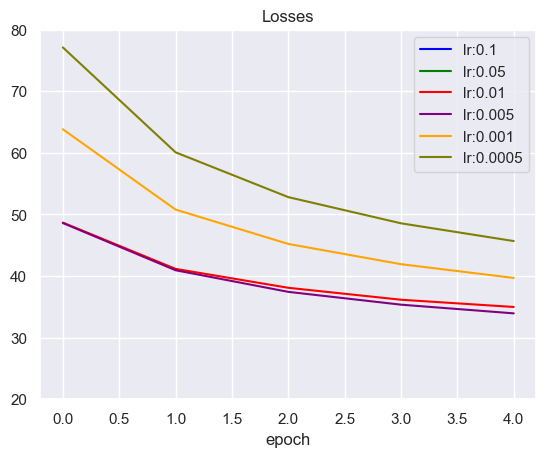

Минимальная perplexities для подхода lr 0.1: 21.36
Минимальная perplexities для подхода lr 0.05: 7.11
Минимальная perplexities для подхода lr 0.01: 3.6
Минимальная perplexities для подхода lr 0.005: 3.56
Минимальная perplexities для подхода lr 0.001: 3.71
Минимальная perplexities для подхода lr 0.0005: 3.85


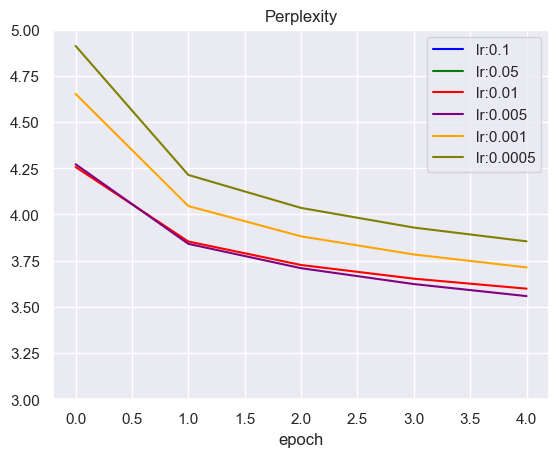

In [115]:
df = pd.read_csv(r'E:\Iliushina_files\DLS\2_part\3. language models\lr_affect.csv') 

colors = ['blue', 'green', 'red', 'purple', 'orange', 'olive', 'c', 'm']

for index, row in df.iterrows():
    lr = row['lr']
    data_loss_v = string_to_list(row['losses'])
    plt.plot(data_loss_v, label='lr:{}'.format(lr), color=colors[index % len(colors)])
plt.ylim(20, 80)
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for index, row in df.iterrows():
    lr = row['lr']
    data_perplexities = string_to_list(row['perplexities'])
    plt.plot(data_perplexities, label='lr:{}'.format(lr), color=colors[index % len(colors)])
    print('Минимальная perplexities для подхода lr {}: {}'.format(lr, round(min(data_perplexities), 2)))
plt.ylim(3, 5)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.legend()
plt.show()

Наилучшие значение перплексии достигаются при lr=0.005 для оптимизатора Adam, что является дефолтным значением, на котором и проводились предыдущие обучения 

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

1. Наилучая модель была обучена в 3 эксперименте, где значение перплексии снизилось до 2.15, что является хорошим значением, учитывая идеальное значение в 1 (в остальных обучениях видно, что обычно значение перплексии варьируется более 3). 
2. Это было достигнуто путем подбора оптимальной модели LSTM (1 эксперимент), подбора lr=0.005 (4 эксперимент) и из прошлой домашней работы были взяты оптимальные параметры n_layers = 2, hidden_dim = 516. Dropout_rate оказывает негативное влияние на качетсво модели, видимо, в задаче генерации очень существенны взаимосвязи между нейронами(что и логично для задачи генерации текста). А нормализация оказывает положительное влияние, уменьшая значение перплексии на 1, по сравнению с аналогичной моделью без нормализации (2 эксперимент).
3. В эксперименте 3 был имплементирован beam method для генерации предложений и сравнен с жадным алгоритмом. Качество генерации сложно сравнить, чаще всего получается бред, но иногда beam все же генерирует предложения лучше.
4. Также была попытка применить beam search для генерации предложений, но код хоть и работает, но показывает странные предсказания, поэтому не работает.
5. В качестве методов для улучшения качества я предлагаю увеличение размера словаря (6000 вместо 4000), потому что часто появляются <unk> токены.